<a href="https://colab.research.google.com/github/pachterlab/GFCP_2021/blob/main/notebooks/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies


In [ ]:
#!git clone https://github.com/pachterlab/GFCP_2021.git
#!cd GFCP_2021
#from vis import * 

In [ ]:
%%capture
pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [ ]:
%%capture
pip install scanpy

In [ ]:
%%capture
pip install umap-learn

In [ ]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "hgForebrainGlut.loom")

('hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7f3052b53b50>)

In [ ]:
!mkdir ../figure data

# vis.py

In [189]:

# ---------------- Simulation -------------

def eval_x_interval(k_,dt,beta,gamma,x0):
    '''
    Evaluates a single gene's average expression at a time point dt after
    the system is started. This solution results from the reaction 
    rate equations, and is specifically implemented for a time interval wherein
    the parameter values are constant.
    
    Parameters
    ----------
    k_: transcription rate (constitutive)
    dt: time since system is started
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    gamma /= beta
    dt *= beta
    k_ /= beta
    x = np.array([k_*(1-np.exp(-dt)) + x0[0]*np.exp(-dt), 
        np.exp(-dt*gamma) * \
        (np.exp(dt*gamma) * k_ * (gamma-1) + \
        - k_*np.exp(dt*(gamma-1))*gamma \
        + k_\
        + (gamma-1)*gamma*x0[1] \
        +gamma*x0[0]*(np.exp((gamma-1)*dt)-1)) \
        /gamma/(gamma-1)])
    return x
def eval_x(k,tau,t,beta,gamma):
    '''
    Evaluates a single gene's average expression at a time point t. 
    This solution derives from the reaction rate equations. The value is 
    computed by evaluating the RREs piecewise over succeeding intervals 
    until time t is reached. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0 (in this case, we assume it starts with Poisson)
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    # x=x0
    x0 = [k[0]/beta, k[0]/gamma]
    x=x0
    ind_last = sum(tau<=t)
    tau = np.concatenate((tau[:(ind_last)],[t]))
    for ind in range(ind_last):
        x = eval_x_interval(k[ind],tau[ind+1]-tau[ind],beta,gamma,x)
    return x

def poiss_samp(k,tau,t,beta,gamma):
    '''
    Simulates a single gene's expression at a time point t. 
    This solution derives from the reaction rate equations. The average 
    expression is computed; then, a Poisson random variable with that 
    expectation is sampled to produce an observation. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: instantaneous expression (vector, unspliced and spliced)
    '''
    x = np.random.poisson(eval_x(k,tau,t,beta,gamma))
    return x

def get_cell_spec_K(K,cell_type):
    k = [K[0],K[1],K[cell_type]]
    return np.array(k)

def simulate_occup_meas(nCells=2000, nGenes=100, T=20, tau = [0,8,13], topo="aba"):
    '''
    Simulates a gene expression given a constitutive model with transient
    dynamics. A vector of observation times is initializated; then, the 
    occupation measures are sampled to produce single-molecule observations
    consistent with canonical RNA velocity models.
    
    Parameters
    ----------
    nCells: number of cells to simulate
    nGenes: number of genes to simulate
    T: process halting time
    tau: process-wide transition times
    topo: string indicating whether the process topology. This defines the 
    transcription rate arrays K over the trajectory.
        "aba": cells are perturbed and return back to the original attractor.
            2 parameters. 
        "ab(a/c)": cells are perturbed; half return and half seek a new attractor.
            3 parameters (one is duplicated).
        "ab(c/d)" cells branch to attractors c and d through b.
            4 parameters.

    Returns
    -------
    X: spliced and unspliced samples from occupation measure
        (array, 2 x nCells x nGenes)
    branch_cells: indices of cells that branch off
    tvec: ground truth pseudotimes
    K: ground truth initiation rates
    g_true: ground truth degradation rates
    b_true: ground truth splicing rates (all 1)
    '''
    #define occupation measure for sampling: df = dt/T
    tvec = np.random.rand(nCells)*T
    #initialize arrays for simulations
    X = np.zeros((2,nCells,nGenes))
    g_true = np.zeros(nGenes)
    b_true = np.zeros(nGenes)
    cell_types = np.zeros(nCells,dtype=int)

    tau = np.array([0,8,13])
    cell_types[tvec<tau[1]] = 0 #a
    cell_types[(tvec>tau[1]) & (tvec<tau[2])] = 1
    if topo == "aba":
        n_K = 2
        cell_types[tvec>tau[2]] = 0
        # print("aba")
    else:
        n_branch_cells = int(nCells/2)
        branch_cells = np.random.choice(nCells,n_branch_cells,False)
        filt = np.zeros(nCells,dtype=bool)
        filt[branch_cells] = True
        if topo == "ab(a/c)":
            n_K = 3
            cell_types[(tvec>tau[2]) & ~filt] = 0
            cell_types[(tvec>tau[2]) & filt] = 2
            print("ab(a/c)")
        if topo == "ab(c/d)":
            n_K = 4
            cell_types[(tvec>tau[2]) & ~filt] = 2
            cell_types[(tvec>tau[2]) & filt] = 3
            print("ab(c/d)")
    # print(cell_types)
    K = np.zeros((nGenes,n_K))


    for j in range(nGenes):
        # print(j)
        FLAG = True
        while FLAG:
            #this defines states a, b, c, d.
            kinit = 10**np.random.normal(0,size=n_K)
            K[j,:] = kinit
            # print(kinit)
            beta = 10**np.random.normal(1,0.5)
            b_true[j]=beta
            gamma = 10**np.random.normal(0.5,0.25)
            # gamma = 10**np.random.normal(0,0.5)
            g_true[j] = gamma

            try: #the simulation procedure is not necessarily stable. If it
                #produces unreasonable samples, we resample the parameters.
                for i in range(nCells):
                    # print(nCells)
                    # x0 = [kinit[0]/beta, kinit[0]/gamma]
                    X[:,i,j]= poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                    # print(i)
                    # if i==0:
                    #     print(K[j,cell_types[i]])
                    #     print(tvec[i])
            except:
                # print(kinit)
                # print(x0)
                # print('big yikes')
                # poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                pass
            
            if ~np.any(np.isnan(X[:,:,j])):
                FLAG=False
    return X,cell_types,tvec,K,g_true,b_true

def sim_export(simdata, name="simdata"):
    X,cell_types,tvec,K,g_true,b_true = simdata
    adata=ad.AnnData(np.sum(X,axis=0))
    adata.layers["spliced"] = X[1,:,:]
    adata.layers["unspliced"] = X[0,:,:]
    adata.layers["ambiguous"]=np.zeros((nCells,nGenes))
    # br = np.zeros(nCells,dtype=bool)
    # br[branch_cells]=True
    adata.obs["time"]=tvec
    adata.obs["celltype"]=cell_types
    adata.var["gamma"]=g_true
    adata.var["beta"]=b_true
    adata.var["Gene"]=np.asarray([str(i) for i in range(nGenes)])
    # adata.uns["K"]=K
    n_K = K.shape[1]
    for i in range(n_K):
        adata.var["k"+str(i)]=K[:,i]
    # adata.var["km"]=K[:,1]
    # adata.var["k1"]=K[:,2]
    # adata.var["k2"]=K[:,3]
    adata.uns['tau']=tau
    adata.write_loom(name+".loom")

In [269]:
#For vlm need to save linear/non-linear pca,t-SNE,UMAP,  and true pseudotime/gamma, cluster labels

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import velocyto as vcy
import anndata as ad
import warnings

# parameter
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex] 
                     
emb_dict={"default":'pcs',"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    

def preprocess(vlm,nGene=1000,filter=True):
    if filter:
        vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
        vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
        vlm.filter_genes(by_detection_levels=True)
        vlm.score_cv_vs_mean(N=nGene, plot=False, max_expr_avg=35)
        vlm.filter_genes(by_cv_vs_mean=True)

    vlm.normalize("both", size=True, log=True)
    vlm.perform_PCA(which="S_norm")
    return


def makeEmbeds(vlm, embeds, x_name="S_norm", new_pca=True):
    '''
    Save embedding objects in embeds lists in vlm
    
    Parameters
    ----------
    vlm : Velocyto loompy object
    x_name: X for embedding, e.g. "S", "S_norm"
    embeds : set of embeddings e.g. {'PCA','UMAP','tSNE'}
    
    Returns
    -------
    '''    
    
    if new_pca or not hasattr(vlm, "PCA"):
        X = getattr(vlm, x_name) # X=(n_samples, n_features)
        vlm.PCA = PCA(n_components=50).fit_transform(X.T)
        
    
    if "PCA" in embeds:
        vlm.ps = np.array(vlm.PCA[:,:2], order="C")
        
    if 'UMAP' in embeds:
        vlm.us = umap.UMAP(n_components=2).fit_transform(vlm.PCA[:, :25])
        
    if 'tSNE' in embeds:
        vlm.ts = TSNE(n_components=2).fit_transform(vlm.PCA[:, :25]) 

    if "default" in embeds:
        vlm.perform_PCA(which=x_name) # default add attr pca and pcs

    return 


def getImputed(vlm, knn_k=50):
    '''
    Get gamma inference from imputed counts
    
    Parameters
    ----------
    
    Returns
    -------
    '''

    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))
    vlm.normalize("imputed", size=True, log=True)

    #Get gamma inference
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=True, \
               weighted=True, weights="maxmin_diag", \
               maxmin_perc=[2,95], limit_gamma=True)
    delta_t = 1
    vlm.used_delta_t = delta_t
    velocity = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    vlm.delta_S = delta_t * velocity # same as vlm.calculate_shift()
    vlm.Sx_sz_t = vlm.Sx_sz + vlm.delta_S  # same as vlm.extrapolate_cell_at_t(delta_t=1)
    return vlm


def getNeighbors(embed, n_neigh = 150, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=150):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    embed1_neighbor = getNeighbors(x1,n_neigh)
    embed2_neighbor = getNeighbors(x2,n_neigh)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        frac[i] = len(inter)/len(set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:]))
    return frac

# def princCurveCompute(ax,vlm,meta):
#     '''
#     Plot principal curve coordinates for linear PCA embedding
    
#     Parameters
#     ----------
    
#     Returns
#     -------
#     '''
#     return


# ---------------- Plotting -------------


def princCurvePlots(ax,vlm,meta):
    '''
    Plot principal curve coordinates for linear PCA embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    nCells,nGenes,T,tau,topo = meta
    nT = 200
    tvec_red = np.linspace(np.min(vlm.ca['time']),np.max(vlm.ca['time']),nT)
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    
    branches = dict_Kval[topo]
    n_branches = len(branches)
    for i in range(n_branches):
        K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
        Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec_red] for j in range(nGenes)]
        Xtheo = np.asarray(Xtheo)
        Xtheo[np.isnan(Xtheo)]=0
        Xtheo[np.isinf(Xtheo)]=0
        Xtheo = np.swapaxes(Xtheo,0,2)

        # print(got)
        Y = vlm.pca.transform(np.log2(Xtheo[1,:,:]+1))
        ax.plot(Y[:,0],Y[:,1],c='k')

    # princCurveCompute(ax,vlm,meta)
    return

def plotJaccard(ax,x1, x2, n_neigh=150):
    '''
    Single jaccard distance plot
    
    Parameters
    ----------
    ax: plot axis
    vlm: velocyto 
    Returns
    -------
    '''
    frac=getJaccard(x1, x2, n_neigh)
    ax.hist(frac, color = vermeer[3], lw=0)
    #ax.set_title('Jaccard distances for neighbors between ' + pair[0] + ' and '  + pair[1])
    return

'''
def jaccardPlots(vlm,pairs,n_neigh):
    
    Plot jaccard distances for neighbors between pairs of embeddings
    
    Parameters
    ----------
    vlm: VelocytoLoom instance
    pairs: tuple of two element tuples, e.g (('ps','ts'),('ts','us'))
    n_neigh: number of neighbors

    Returns
    -------
    fig: figure
    
    emb_set=set(emb for pair in pairs for emb in pair)
    for emb in emb_set:
        if emb not in ("PCA","UMAP",'tSNE'):
            raise NameError('only support PCA, UMAP and tSNE')
    makeEmbeds(vlm, emb_set,x_name='Sx_sz')

    n=len(pairs)
    fig, ax = plt.subplots(1,n, figsize=(6*n,4))
    if n==1:
        plotJaccard(ax,vlm,pairs[0],n_neigh)
    else:
        for i in range(n):
            plotJaccard(ax[i],vlm, pairs[i],n_neigh)
    return
'''

def plotPhase(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux[gene_idx,:]
    x=vlm.Sx[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    
    ax.plot(x, y, '.',color=vermeer[3])
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b, color=vermeer[0],linewidth=4)
    return

def plotGammaK(ax, vlm, gene_idx, n_neigh, gamma, q, sim=False):
    '''
    Plot gamma over k neighbors for gene at gene_idx
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    ax.scatter(n_neigh, gamma, color=vermeer[0],label="gamma")
    if sim:
        ax.plot(n_neigh,vlm.ra["gamma"][gene_idx]/vlm.ra["beta"][gene_idx]*np.ones(len(n_neigh)),'r-',label="true gamma/beta")
        # print(vlm.ra['gamma'][gene_idx])
    ax.set_xlabel("k neighbors")
    ax.set_ylabel("gamma")
    ax.yaxis.label.set_color(vermeer[0])
    frac=vlm.Ux[gene_idx,:,None] - vlm.Sx[gene_idx,:,None]*gamma[None,:] + q[None,:]
    frac=np.sum(frac>0,axis=0)/np.shape(frac)[0]
    ax2=ax.twinx()
    ax2.scatter(n_neigh, frac, color=vermeer[3],label="frac")
    ax2.set_ylabel("perc cells unregulated")
    ax2.yaxis.label.set_color(vermeer[3])
    ax2.set_ylim([0,1])
    return

def phasePlots(vlm,genes, n_neighs,n_neighs_list,sim=False,zero_is_special=True):
    '''
    Plot phase portraits with gamma distributions for various genes across n_neighs
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    if type(genes) is list or type(genes) is tuple: #looking at SPECIFIC genes enumerated in an iterable
        m = len(genes)
    else: #just some random genes
        m = genes
        genes = np.random.choice(vlm.ra['Gene'],m,replace=False)
    
    
    n = len(n_neighs)
    n2 = len(n_neighs_list)
    gammas = np.zeros((m,n2))
    q = np.zeros((m,n2))
    
    fig, ax = plt.subplots(m,n+1,figsize=((n+1)*6,m*4))
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.005))[0][0]
    
    for j, knn_k in enumerate(n_neighs):      
        if knn_k>0:
            vlm.knn_imputation(k=knn_k, n_pca_dims=n_comps)
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U         
        # use default setting
        vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")

        if knn_k==0 and zero_is_special:
            vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False)

        #For genes 1...n
        for i, gene in enumerate(genes):
            gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
            plotPhase(ax[i][j], vlm, gene_idx)       
            
    for j, k in enumerate(n_neighs_list):
        knn_k=int(k)
        if knn_k>0:
            vlm.knn_imputation(k=knn_k, n_pca_dims=n_comps)
        else:
            vlm.Sx=vlm.S
            vlm.Ux=vlm.U         
        # use default setting
        vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
        if knn_k==0 and zero_is_special:
            vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False)

           
        for i, gene in enumerate(genes):
            gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
            gammas[i,j]=vlm.gammas[gene_idx]
            q[i,j]=vlm.q[gene_idx]
            
    for i, gene in enumerate(genes):
        gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
        plotGammaK(ax[i][n], vlm, gene_idx, n_neighs_list, gammas[i,:], q[i,:], sim=sim)
    return fig


def plotEmbed(ax,vlm,embed,c='gray'):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    ax.scatter(x[:,0],x[:,1],marker=".",c=c)
    return


def plotGrid(ax,vlm,gridx,gridv,trans,c='b'):
    '''
    Plot grid with arrows given embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    x=getattr(vlm, gridx)
    v=getattr(vlm, gridv)
    masks=vlm.total_p_mass>0.01
    ax.quiver(x[masks, 0], x[masks, 1], v[masks, 0], v[masks, 1], color=c, alpha=0.8, linewidth=6.5, scale=10, label=trans)
    return


def gridArrowPlots(vlm,Trans,embed,sim=False,meta=None,ax=None,legend=True):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    if not hasattr(vlm,"Sx_sz_t"):
        getImputed(vlm, knn_k=50)
    emb=emb_dict[embed]
    makeEmbeds(vlm, embeds=embed, x_name='S_norm', new_pca=False)
    
    if ax is None:
        fig,ax=plt.subplots(1,1)

    if sim and embed=="PCA":
        princCurvePlots(ax,vlm,meta)

    if sim:
        plotEmbed(ax, vlm, emb, c=vlm.ca["time"])
    else:
        labels = vlm.ca["Clusters"]
        manual_annotation = {str(i):[i] for i in labels}
        annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
        clusters = np.array([annotation_dict[i] for i in labels])
        colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
        vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})
        plotEmbed(ax, vlm, emb, c=vlm.colorandum)

    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                    n_neighbors=150, knn_random=False, sampled_fraction=1)
        
        if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
            warnings.warn("Nan values in corrcoef, setting them to 0") 
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=0
            
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25), n_neighbors=100)
        
        plotGrid(ax,vlm,"flow_grid","flow",trans,c=vermeer[0])
        # plotGrid(ax,vlm,"flow_grid","flow",trans,c=vermeer[-i-1])
        
    if legend:
        ax.legend()
    if ax is None:
        return fig
    else:
        return ax



def plotTheta(ax, X, Y, k):
    '''
    Single angle deviation plot
    '''
    angle1=np.arctan2(X[:,1],X[:,0])
    angle2=np.arctan2(Y[:,1],Y[:,0])
    angle=angle2-angle1
    angle[angle>np.pi]=angle[angle>np.pi]-2*np.pi
    angle[angle<-np.pi]=angle[angle<-np.pi]+2*np.pi
    ax.hist(angle,density=True,label=str(k),alpha=0.2)
    ax.set_xlabel("angle")
    ax.set_ylabel("density")
    return 

def angleDevPlots(vlm,Trans,n_neigh,embed="PCA"):
    '''
    Plot angle deviations from transformations over varying neighbors for embedding (only compared to baseline)
    
    Parameters
    ----------

    Returns
    -------
    '''
    if not hasattr(vlm,"Sx_sz_t"):
        getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
    emb=emb_dict[embed]
    fig, ax= plt.subplots(1, len(Trans),figsize=(len(Trans)*6,4))
 
    for j, k in enumerate(n_neigh):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform="linear", 
                                        n_neighbors=k, knn_random=False, sampled_fraction=1)
        if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
            warnings.warn("Nan values in corrcoef, setting them to 0") 
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=0
              
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        baseline_arrow=vlm.delta_embedding
        
        for i,trans in enumerate(Trans):       
            vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                          n_neighbors=k, knn_random=False, sampled_fraction=1)
            if np.count_nonzero(np.isnan(vlm.corrcoef))>0:
                warnings.warn("Nan values in corrcoef, setting them to 0") 
                vlm.corrcoef[np.isnan(vlm.corrcoef)]=0
                
            vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
            
            plotTheta(ax[i], baseline_arrow, vlm.delta_embedding, k)
            
    plt.legend()
        
    return fig



In [267]:
# def simPdfPlot(ax,vlm):
#     pmf_nas = get_nas(K,tau,T,beta,np.max(Xg[0]))
#     pmf_mat = get_mat(K,tau,T,beta,gamma,np.max(Xg[1]))
def simValidPlots(vlm,tau,geneind=0,knn_k=50):
    '''
    Plot sim validation figures.
    These should be later combined into a single figure, instead of several.
    MAKE SURE THE IMPUTATION HAPPENS.
    '''
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.005))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))



    fig1, ax1 = plt.subplots(1, 3,figsize=(3*6,4))
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=False, weighted=False)
    plotGamma(ax1[0],vlm)
    vlm.fit_gammas(use_imputed_data=False, use_size_norm=True, weighted=True, weights="maxmin_diag")
    plotGamma(ax1[1],vlm)
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=False, weighted=True, weights="maxmin_diag")
    plotGamma(ax1[2],vlm)


    Xtheo = getGroundTruthAvg(vlm,tau)

    fig2, ax2 = plt.subplots(1, 3,figsize=(3*6,4))
    selection_names = ['raw','size_norm','imputed']
    for i in range(3):
        plotSimCounts(ax2[i],vlm,geneind,selection_names[i])
        plotGroundTruthCounts(ax2[i],vlm,geneind,tau)
    
    fig3, ax3 = plt.subplots(1, 2,figsize=(2*6,4))
    selection_names = ['U','S']
    for i in range(2):
        plotImpPerformance(ax3[i],vlm,Xtheo,selection_names[i])

def plotImpPerformance(ax,vlm,Xtheo,selection):
    if selection is 'U':
        field_str = 'Ux'
        i = 0
    elif selection is 'S':
        field_str = 'Sx'
        i = 1
    ground_truth = Xtheo[i].T.flatten()
    imputed_value = getattr(vlm,field_str).flatten()
    ax.loglog(ground_truth,imputed_value,'k.')
    xl = np.linspace(min(ground_truth),max(ground_truth))
    ax.plot(xl,xl,'r-',linewidth=2)
    ax.plot(xl,xl*10,'b-')
    ax.plot(xl,xl/10,'b-')
    ax.set_xlabel(selection + ' ground truth mean')
    ax.set_ylabel(selection + ' imputed mean')


def getGroundTruthAvg(vlm,tau):
    i=0  #just recycling the more generic code
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec] for j in range(nGenes)]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0
    Xtheo = np.swapaxes(Xtheo,0,2)
    return Xtheo

def plotGamma(ax,vlm):
    x = vlm.ra['gamma']/vlm.ra['beta']
    tmp = vlm.gammas
    vlm.gammas[vlm.gammas<1e-4]=1e-4
    ax.loglog(x,vlm.gammas,'k.')
    xl = np.linspace(min(x),max(x))
    ax.plot(xl,xl,'r-',linewidth=2)
    ax.plot(xl,xl*10,'b-')
    ax.plot(xl,xl/10,'b-')
    vlm.gammas = tmp

def plotSimCounts(ax,vlm,geneind,selection):
    if selection is 'raw':
        U_str = 'U'
        S_str = 'S'
    elif selection is 'size_norm':
        U_str = 'U_sz'
        S_str = 'S_sz'
    elif selection is 'imputed':
        U_str = 'Ux'
        S_str = 'Sx'
    U = getattr(vlm,U_str)[geneind,:]
    S = getattr(vlm,S_str)[geneind,:]
    tvec = vlm.ca['time']
    ax.plot(tvec,U,'.')
    ax.plot(tvec,S,'.')

def plotGroundTruthCounts(ax,vlm,geneind,tau):
    #there are better ways to do this

    j=geneind
    tvec = vlm.ca['time']
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
    
    branches = dict_Kval[topo]
    n_branches = len(branches)

    i=0
    Xtheo = [eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec]
    Xtheo = np.asarray(Xtheo)
    Xtheo[np.isnan(Xtheo)]=0
    Xtheo[np.isinf(Xtheo)]=0

    I_ = np.argsort(tvec)
    tvec = tvec[I_]
    Xtheo = Xtheo[I_]
    ax.plot(tvec,Xtheo,linewidth=2)

    # x0 = [K[geneind,0],K[geneind,0]/g_true[geneind]]
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[0] for t in tvec],'k.')
    # plt.plot(tvec,[eval_x(K[geneind,:],tau,t,1,g_true[geneind],x0)[1] for t in tvec],'r.')

In [172]:
# vlm.S.shape   

(100, 2000)

In [173]:
# vlm.ca.keys()

dict_keys(['celltype', 'obs_names', 'time'])

# Forebrain data

In [226]:
vlm = vcy.VelocytoLoom(loom_filepath="./hgForebrainGlut.loom")
preprocess(vlm)

In [227]:
vlm.S.shape

(1001, 1711)

(array([ 95.,   0.,   0.,  26.,  92., 162., 272., 232., 104.,  18.]),
 array([-6.        , -5.26598098, -4.53196195, -3.79794293, -3.06392391,
        -2.32990488, -1.59588586, -0.86186684, -0.12784781,  0.60617121,
         1.34019024]),
 <a list of 10 Patch objects>)

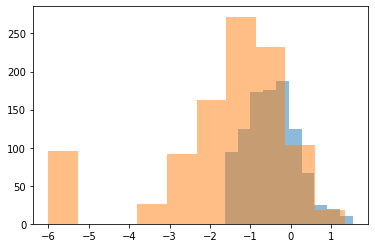

In [228]:
plt.hist(np.log10(1e-6+np.mean(vlm.S,axis=1)),alpha=0.5)
plt.hist(np.log10(1e-6+np.mean(vlm.U,axis=1)),alpha=0.5)

average expression of spliced is just over 1. Average expression of unspliced is under 1.

In [229]:
np.mean(vlm.S)

1.1361829287019234

In [230]:
np.mean(vlm.U)

0.4116070954177325

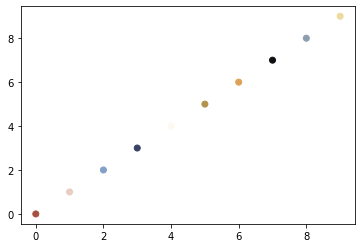

In [231]:
plt.scatter(np.arange(10),np.arange(10),c=vermeer)

## phasePlots

In [232]:
import time


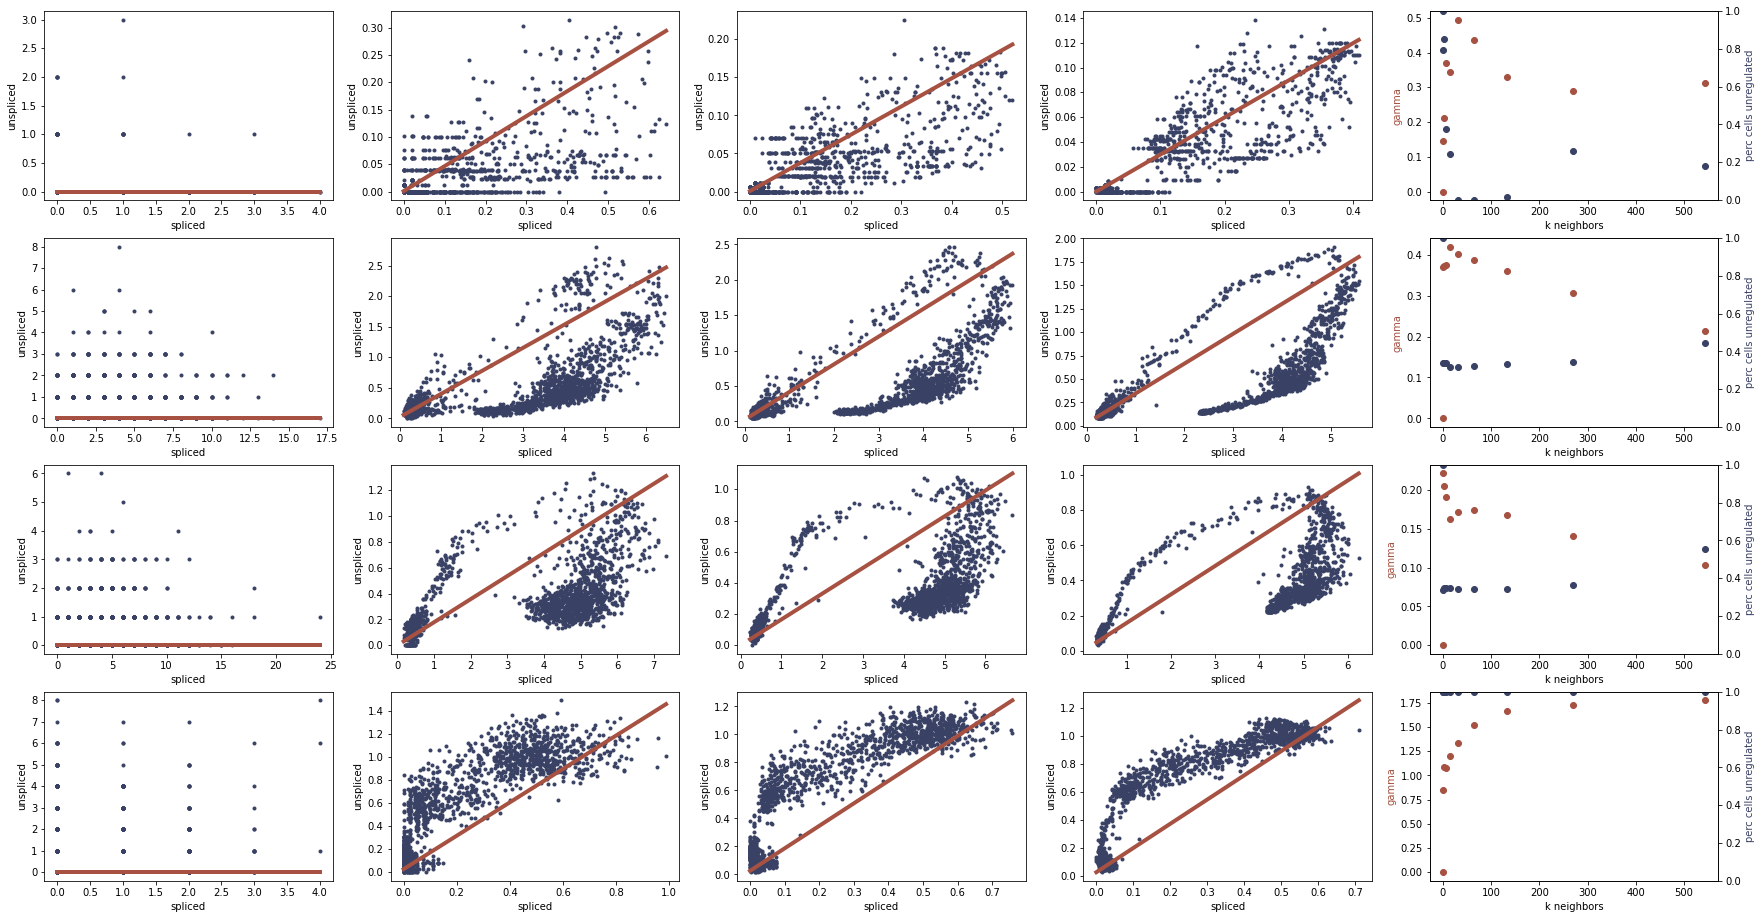

In [235]:
t1 = time.time()
fig=phasePlots(vlm,genes=["FAM64A","ELAVL4","DCX","GRIA3"],n_neighs=[0,50,100,200],n_neighs_list=np.exp(np.arange(0,7,0.7))-1,sim=False,zero_is_special=False)
dtime = time.time()-t1

In [234]:
print('Runtime: {:.1f} seconds.'.format(dtime))

Runtime: 32.6 seconds.


In [ ]:
fig.savefig('../figure/figure_6.png',dpi=450)

## jaccardPlots

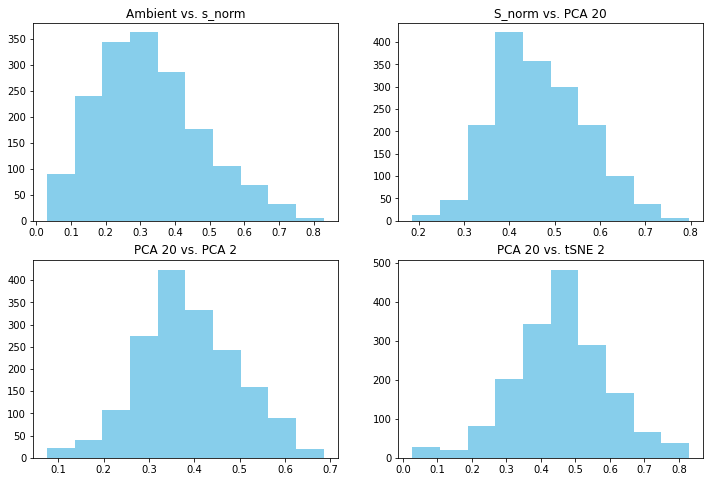

In [ ]:
fig, ax=plt.subplots(2,2,figsize=(12,8))

ax[0,0].set_title("Ambient vs. s_norm")
plotJaccard(ax[0,0], vlm.S.T, vlm.S_norm.T, n_neigh=150)

ax[0,1].set_title("S_norm vs. PCA 20")
plotJaccard(ax[0,1],vlm.pcs[:,:20], vlm.S_norm.T,n_neigh=150)

ax[1,0].set_title("PCA 20 vs. PCA 2")
plotJaccard(ax[1,0],vlm.pcs[:,:20],vlm.pcs[:,:2],n_neigh=150)

ax[1,1].set_title("PCA 20 vs. tSNE 2")
makeEmbeds(vlm, embeds="tSNE", x_name="S_norm")
plotJaccard(ax[1,1],vlm.pcs[:,:20], vlm.ts, n_neigh=150)

fig.savefig('../figure/figure_7_a.png',dpi=450)

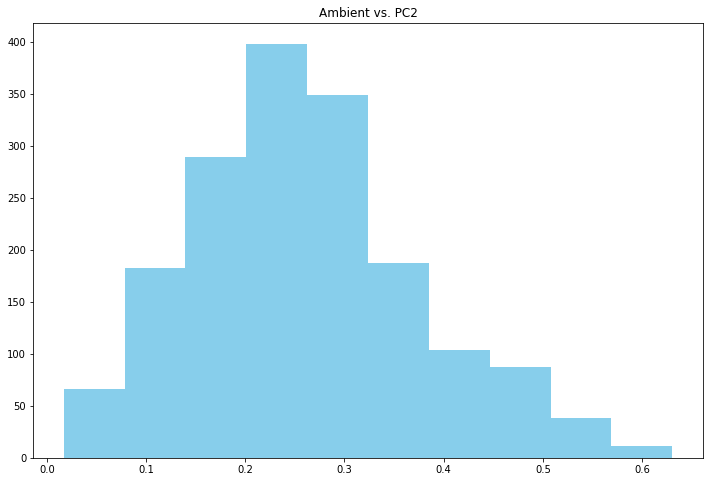

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
ax.set_title("Ambient vs. PC2")
plotJaccard(ax,vlm.pcs[:,:2], vlm.S.T, n_neigh=150)
fig.savefig('../figure/figure_7_b.png',dpi=450)

## angleDevPlots

KeyboardInterrupt: ignored

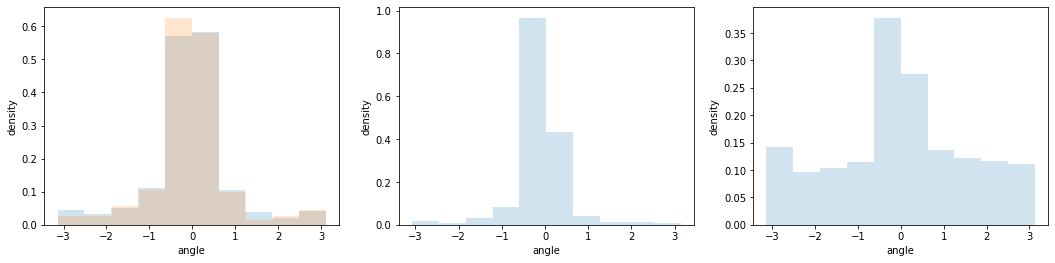

In [270]:
fig=angleDevPlots(vlm,Trans=["sqrt","log","bool"],n_neigh=[50,100,200],embed="PCA")
fig.savefig('../figure/figure_8.png',dpi=450)

## gridArrowPlots

<AxesSubplot:>

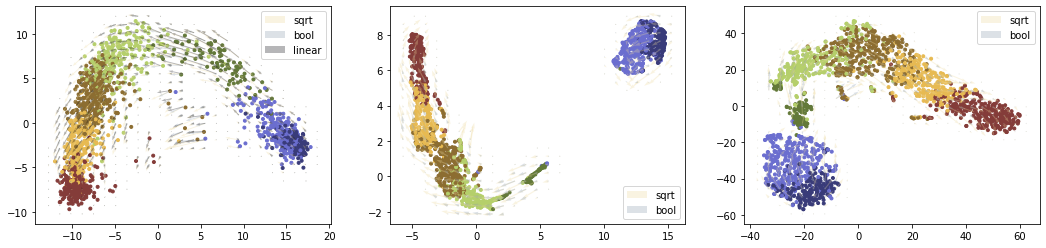

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(18,4))
gridArrowPlots(vlm,Trans=["sqrt","bool","linear"],embed="PCA",sim=False,ax=ax[0])
gridArrowPlots(vlm,Trans=["sqrt","bool"],embed="UMAP",sim=False,ax=ax[1])
gridArrowPlots(vlm,Trans=["sqrt","bool"],embed="tSNE",sim=False,ax=ax[2])

In [ ]:
fig.savefig('../figure/figure_9.png',dpi=450)

# Simulation

Generate simulation data

In [247]:
nCells,nGenes,T,tau,topo =  2000,100,20,[0,8,13],"aba"
meta = nCells,nGenes,T,tau,topo

In [248]:
simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo)

In [249]:
sim_export(simdata)

In [250]:
vlm = vcy.VelocytoLoom(loom_filepath="simdata.loom")
preprocess(vlm,filter=False)

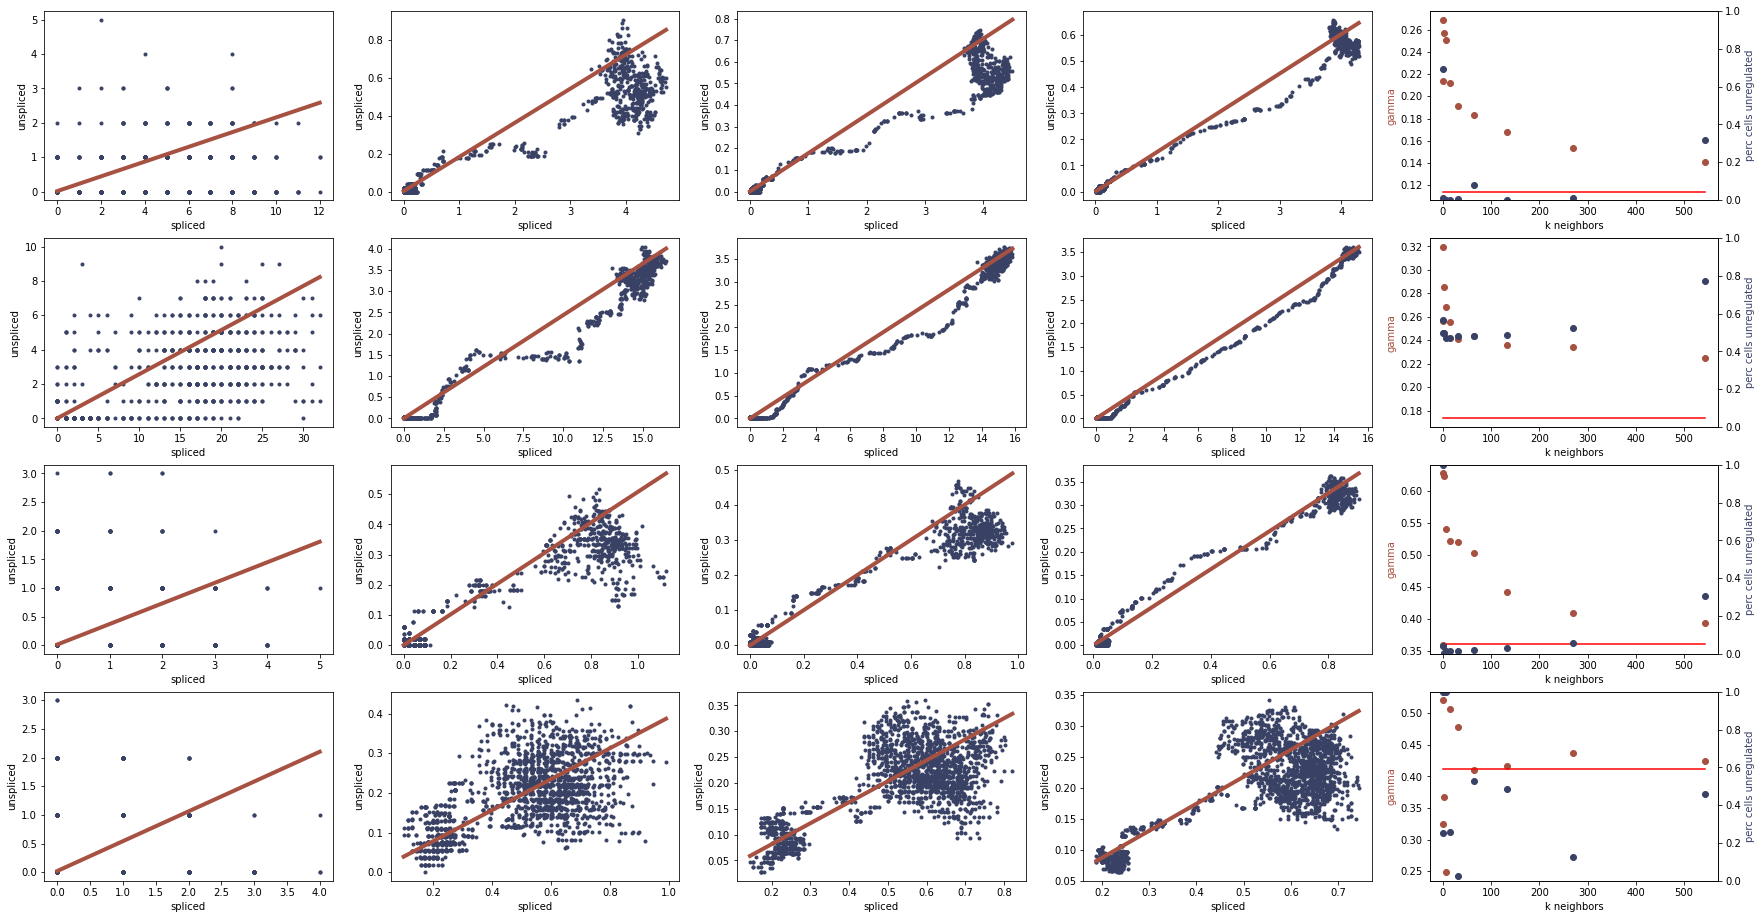

In [261]:
# fig=phasePlots(vlm,n_neighs=[0,10,50,100],genes=3,sim=True)
fig=phasePlots(vlm,genes=4,n_neighs=[0,50,100,200],n_neighs_list=np.exp(np.arange(0,7,0.7))-1,sim=True,zero_is_special=False)


In [262]:
vlm.S.shape

(100, 2000)

Text(0.5, 0, 'log average expression (+1e-6)')

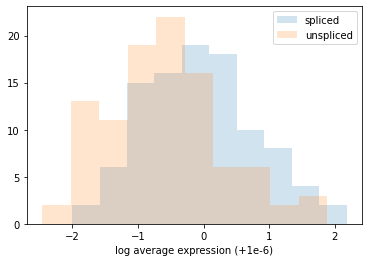

In [263]:
plt.hist(np.log10(vlm.S.mean(axis=1)+1e-6),label='spliced',alpha=0.2)
plt.hist(np.log10(vlm.U.mean(axis=1)+1e-6),label='unspliced',alpha=0.2)
plt.legend()
plt.xlabel('log average expression (+1e-6)')

In [264]:
vlm.S.mean()

6.09437

In [265]:
vlm.U.mean()

3.002005

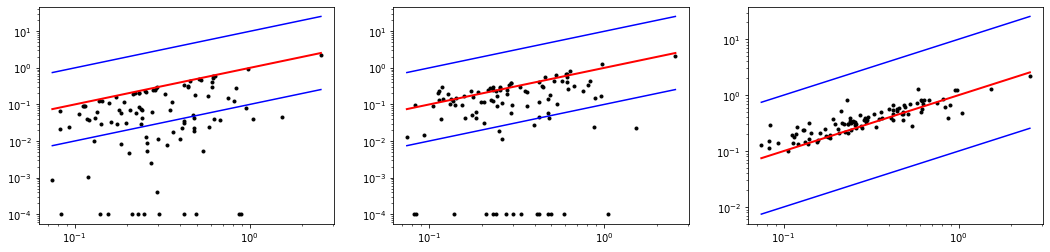

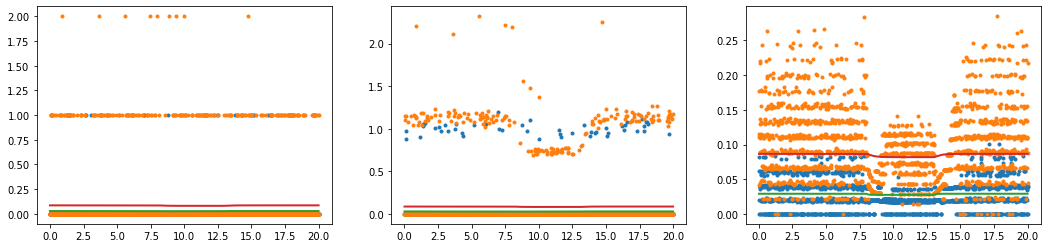

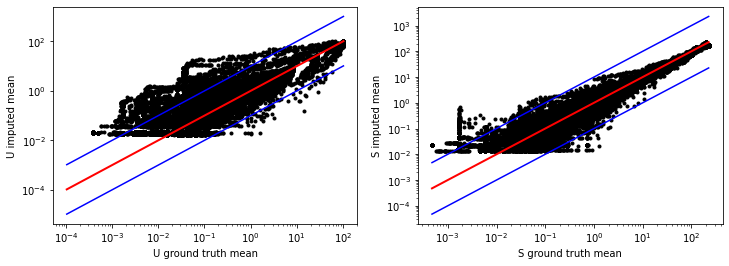

In [268]:
simValidPlots(vlm,tau,geneind=3)

Let's do just like a whole lot of simulations

So, here is the issue. 2k cells @ 100 genes takes about half a minute to simulate. Velocity performance is very inconsistent: sometimes it's basically ok and concordant, sometimes it catastrophically fails and completely flips the arrows wrt the true dynamics. 

We want to be able to illustrate both cases (potentially for a supp. fig). But more than that -- we *have to* have reproducibility using a simple seed.

ab(c/d)
Runtime: 16.6 seconds.


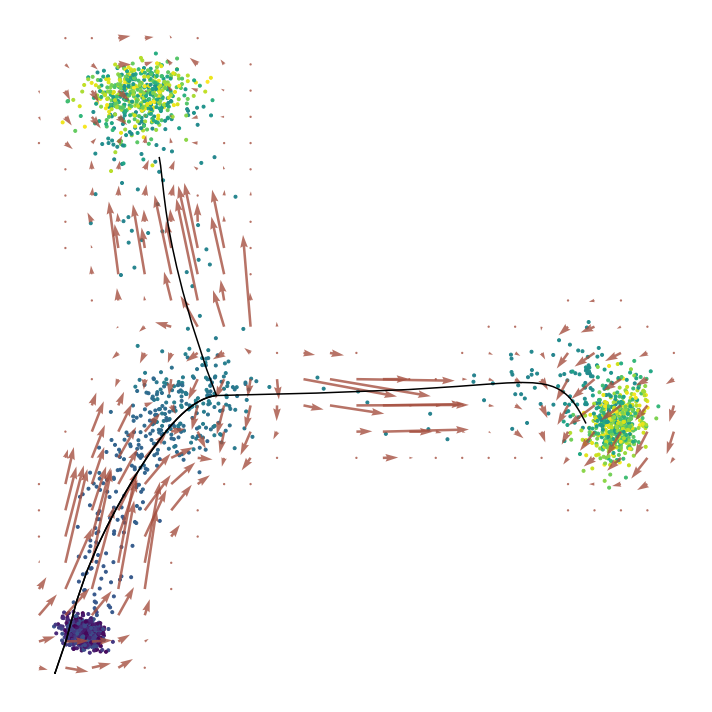

In [219]:
nCells,nGenes,T,tau,topo =  2000,50,30,[0,5,13],"ab(c/d)"
meta = nCells,nGenes,T,tau,topo
import time
t1 = time.time()

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
rs = RandomState(MT19937(SeedSequence(2812)))

import warnings
warnings.filterwarnings("ignore")


szfig = [1,1]
N = np.prod(szfig)
fig1,ax1 = plt.subplots(szfig[0],szfig[1],figsize=[10,10])
for i_ in range(N):
    axl = np.unravel_index(i_,szfig)

    simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo)
    sim_export(simdata)
    vlm = vcy.VelocytoLoom(loom_filepath="simdata.loom")
    preprocess(vlm,filter=False)
    
    gridArrowPlots(vlm,Trans=["sqrt"],embed="PCA",sim=True,meta=meta,ax=ax1,legend=False)
    ax1.axis('off')
    # ax1[axl].axis('off')


fig1.tight_layout()
dtime = time.time()-t1
print('Runtime: {:.1f} seconds.'.format(dtime))
# fig1.savefig('../figure/bigcompare.png',dpi=450)

In [ ]:
fig1.savefig('./bigcompare.png',dpi=450)

In [ ]:
np.sum(vlm.S.mean(axis=1)>100)

27

In [ ]:
np.sum(vlm.U.mean(axis=1)>100)

18

In [221]:
corr = np.corrcoef(vlm.S)

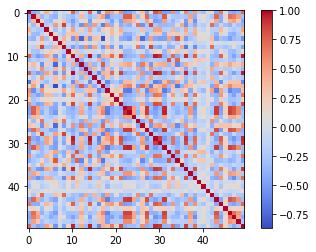

In [222]:
plt.imshow(corr,cmap='coolwarm',interpolation='nearest')
plt.colorbar()

this looks a little weird

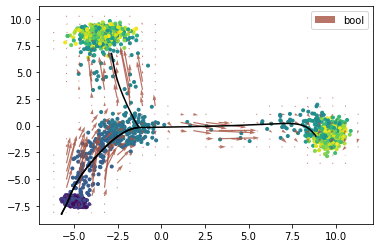

In [223]:
gridArrowPlots(vlm,Trans=["bool"],embed="PCA",sim=True,meta = meta)

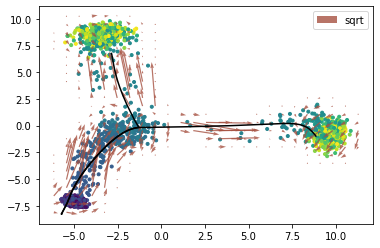

In [224]:
gridArrowPlots(vlm,Trans=["sqrt"],embed="PCA",sim=True,meta = meta)

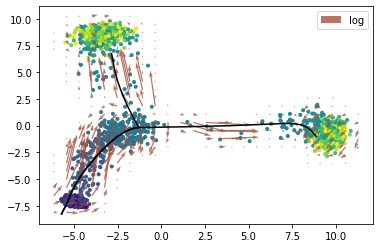

In [225]:
gridArrowPlots(vlm,Trans=["log"],embed="PCA",sim=True,meta = meta)

In [ ]:
# vlm.ra['gamma']

array([1.79502797e+00, 4.40066011e-02, 1.81760295e+00, 7.16745653e-01,
       1.96777051e+01, 2.28120263e+00, 5.05928920e-02, 1.31748558e+01,
       5.53571443e+02, 8.27991873e-01, 1.92551792e-01, 2.91187023e+00,
       5.47181569e-01, 2.55842293e+01, 1.11245883e+00, 1.14053548e+02,
       1.21661789e-01, 9.65383439e+00, 3.42274547e-01, 2.80785975e-01,
       5.22330974e+00, 4.90498413e-02, 1.72071724e+01, 1.05898674e+00,
       9.13267576e-01, 4.00405908e-02, 4.15315102e+00, 1.30426358e+03,
       5.20268186e-01, 6.57759082e-02, 1.08539015e+00, 1.10309756e+00,
       1.90436145e-01, 2.46168728e+00, 2.48705097e+02, 5.14404672e+00,
       4.02088777e+00, 3.30051949e+00, 1.56143948e+01, 1.87285420e-01,
       2.50157131e-01, 4.15425501e-01, 1.43953953e+00, 4.86288561e-01,
       2.51754396e-02, 2.42080562e-01, 2.16087036e-02, 1.35645641e-01,
       1.77568016e-01, 2.82024538e+00, 1.00738252e+01, 2.97312686e-02,
       1.30102749e-02, 1.39122046e+01, 1.82443963e+01, 8.57244236e-01,
      

In [ ]:
getImputed(vlm, knn_k=50)
#makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
vlm.estimate_transition_prob(hidim="Sx_sz", embed="pcs", transform="bool", n_neighbors=150, knn_random=False, sampled_fraction=1)

In [ ]:
np.shape(vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)])
#vlm.corrcoef_random
#vlm.corrcoef[np.isnan(vlm.corrcoef)]=1


(0,)

In [ ]:
np.sum(vlm.corrcoef_random==-1)

0